# CS 109B Advanced Topics in Data Science, Final Project, Milestone 2

## Group 9 - Steve Robbins, Chad Tsang, and Ted Heuer
**Harvard University**<br>
**Spring 2017**<br>
**Due Date: ** Wednesday, April 12th, 2017 at 11:59pm

## Milestone 2: Assembling training data, due Wednesday, April 12, 2017

We are aware that you have little time this week, due to the midterm. So this milestone is a bit easier to achieve than the others. The goal for this week is to prepare the data for the modeling phase of the project. You should end up with a typical data setup of training data X and data labels Y.

The exact form of X and Y depends on the ideas you had previously. In general though Y should involve the genre of a movie, and X the features you want to include to predict the genre. Remember from the lecture that more features does not necessarily equal better prediction performance. Use your application knowledge and the insight you gathered from your genre pair analysis and additional EDA to design Y. Do you want to include all genres? Are there genres that you assume to be easier to separate than others? Are there genres that could be grouped together? There is no one right answer here. We are looking for your insight, so be sure to describe your decision process in your notebook. 

In preparation for the deep learning part we strongly encourage you to have two sets of training data X, one with the metadata and one with the movie posters. Make sure to have a common key, like the movie ID, to be able to link the two sets together. Also be mindful of the data rate when you obtain the posters. Time your requests and choose which poster resolution you need. In most cases w500 should be sufficient, and probably a lower resolution will be fine.

The notebook to submit this week should at least include:

- Discussion about the imbalanced nature of the data and how you want to address it
- Description of your data
- What does your choice of Y look like?
- Which features do you choose for X and why? 
- How do you sample your data, how many samples, and why?

*Important*: You do not need to upload the data itself to Canvas.

### Install Packages

In [1]:
#!pip install IMDbPY
#(only supported in Python 2)
# Documentation for IMDb library:  
        # http://imdbpy.sourceforge.net/support.html#documentation
        # http://imdbpy.sourceforge.net/docs/README.package.txt

In [2]:
#!pip install tmdbsimple
# Documentation for TMDb library
        # https://github.com/celiao/tmdbsimple/
        # (good resource) https://developers.themoviedb.org/3/discover/movie-discover

In [3]:
from IPython.display import Image
import urllib

from imdb import IMDb
import tmdbsimple as tmdb
tmdb.API_KEY = 'c5d41f08e55fca6e9f5fc0b6d1735540'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cmx
import matplotlib.colors as colors
from pandas.tools.plotting import scatter_matrix

### TMDb Genres

In [5]:
num_genres = len(tmdb.Genres().list()['genres'])

idx = range(0, num_genres)
cols = ['genre_id', 'genre']

tmdb_genre_df = pd.DataFrame(index=idx, columns=cols)

In [6]:
for i in range(0, num_genres):
    tmdb_genre_df['genre_id'][i] = tmdb.Genres().list()['genres'][i].values()[0]
    tmdb_genre_df['genre'][i] = tmdb.Genres().list()['genres'][i].values()[1]

In [7]:
foreign_df = pd.DataFrame([[10769, 'Foreign']], columns=cols) #add Foreign Movies (old genre that no longer exists)

tmdb_genre_df = tmdb_genre_df.append(foreign_df, ignore_index=True)

In [8]:
tmdb_genre_df

,genre_id,genre
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


### Get Genre Listings for Large Sample of Movies

In [9]:
discover = tmdb.Discover()

In [10]:
def movie_genres_list(year, min_votes):
        
    movies_in_year = discover.movie(primary_release_year=year, vote_count_gte=min_votes)
    max_page = (movies_in_year['total_pages'] - 1)
    movies_per_page = 20 #always 20 entries per page

    idx = range(0, max_page * movies_per_page)
    cols = ['movie_id', 'num_genres', 'id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7']

    movies_genres_table = pd.DataFrame(index=idx, columns=cols)
    
    for i in range(0, max_page):
        movies_page = discover.movie(page=(i+1), primary_release_year=year, vote_count_gte=min_votes, sort_by='vote_count.desc')

        for j in range(0, movies_per_page):
            genre_list = movies_page['results'][j]['genre_ids']
            row_num = i * movies_per_page + j
            movies_genres_table.iloc[row_num, 0] = movies_page['results'][j]['id']
            movies_genres_table.iloc[row_num, 1] = len(genre_list)

            for k in range(0, len(genre_list)):
                movies_genres_table.loc[row_num][k+2] = genre_list[k]
                
    return movies_genres_table

In [11]:
min_votes=25

In [12]:
movies_2016 = movie_genres_list(year=2016, min_votes=min_votes)

In [13]:
movies_2015 = movie_genres_list(year=2015, min_votes=min_votes)

In [14]:
movies_2014 = movie_genres_list(year=2014, min_votes=min_votes)

In [15]:
movies_2013 = movie_genres_list(year=2013, min_votes=min_votes)

In [16]:
movies_2012 = movie_genres_list(year=2012, min_votes=min_votes)

In [17]:
movies_2011 = movie_genres_list(year=2011, min_votes=min_votes)

In [18]:
movies_genres_table = pd.concat([movies_2016, movies_2015, movies_2014, movies_2013, movies_2012, movies_2011])

In [19]:
movies_genres_table.iloc[:10, :]

,movie_id,num_genres,id_1,id_2,id_3,id_4,id_5,id_6,id_7
0,293660,4,28,12,35,10749,NaN,NaN,NaN
1,297761,4,28,80,14,878,NaN,NaN,NaN
2,209112,3,28,12,14,NaN,NaN,NaN,NaN
3,271110,3,12,28,878,NaN,NaN,NaN,NaN
4,329865,4,53,18,878,9648,NaN,NaN,NaN
5,284052,4,28,12,14,878,NaN,NaN,NaN
6,246655,4,28,12,14,878,NaN,NaN,NaN
7,269149,4,16,12,10751,35,NaN,NaN,NaN
8,259316,3,12,28,14,NaN,NaN,NaN,NaN
9,330459,4,28,18,878,10752,NaN,NaN,NaN


In [20]:
movies_genres_table.shape

(3600, 9)

### Create Table Showing How Genres Relate to Eachother

In [21]:
def create_genre_pairs(tmdb_genre_df, movies_genres_table):

    idx = tmdb_genre_df['genre_id']
    cols = tmdb_genre_df['genre_id']

    genre_pairs_table = pd.DataFrame(index=idx, columns=cols)
    genre_pairs_table = genre_pairs_table.fillna(0)

    total_movies = len(movies_genres_table)

    for row_num in range(0, total_movies):

        num_genres = movies_genres_table.iloc[row_num, 1]

        for i in range(0, num_genres):

            for j in range(0, num_genres):

                x = movies_genres_table.iloc[row_num, i+2]
                y = movies_genres_table.iloc[row_num, j+2]
                genre_pairs_table.loc[x, y] = genre_pairs_table.loc[x, y] + 1

    genre_pairs_table_names = genre_pairs_table.copy()

    new_idx = tmdb_genre_df['genre']
    new_cols = tmdb_genre_df['genre']

    genre_pairs_table_names.columns = new_cols
    genre_pairs_table_names = genre_pairs_table_names.set_index(new_idx)

    return genre_pairs_table_names

In [22]:
genre_pairs = create_genre_pairs(tmdb_genre_df, movies_genres_table)

In [23]:
genre_pairs

genre,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,Foreign
genre,,,,,,,,,,,,,,,,,,,,
Action,727,195,68,121,170,2,200,25,89,24,50,2,35,29,169,4,283,34,10,1
Adventure,195,402,101,103,15,6,73,98,108,14,9,2,11,25,99,6,54,9,7,0
Animation,68,101,251,98,6,5,27,135,66,1,3,6,6,11,35,5,6,0,2,0
Comedy,121,103,98,1178,72,9,348,116,71,7,68,43,19,234,48,11,51,4,5,3
Crime,170,15,6,72,374,7,209,2,5,4,10,3,56,13,7,3,219,2,4,0
Documentary,2,6,5,9,7,201,16,7,0,9,1,25,1,0,1,2,1,4,0,1
Drama,200,73,27,348,209,16,1545,30,63,84,69,60,88,267,81,24,376,62,17,1
Family,25,98,135,116,2,7,30,225,55,1,0,14,3,12,14,12,0,0,1,0
Fantasy,89,108,66,71,5,0,63,55,245,1,28,7,12,33,51,2,30,1,1,0


### Total Number of Genre Listings for All Movies

In [24]:
def get_genre_totals(tmdb_genre_df, genre_pairs):

    idx = tmdb_genre_df['genre']
    cols = ['num_movies_with_genre']

    genre_totals = pd.DataFrame(index=idx, columns=cols)

    for i in range(0, len(genre_totals)):
        genre_totals.iloc[i,0] = genre_pairs.ix[tmdb_genre_df['genre'][i], tmdb_genre_df['genre'][i]]
        
    return genre_totals

In [25]:
genre_totals = get_genre_totals(tmdb_genre_df, genre_pairs)
genre_totals

,num_movies_with_genre
genre,
Action,727
Adventure,402
Animation,251
Comedy,1178
Crime,374
Documentary,201
Drama,1545
Family,225
Fantasy,245


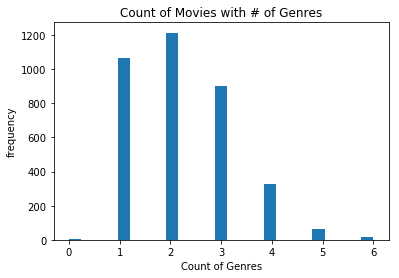

In [26]:
plt.hist(movies_genres_table['num_genres'].values, 
     25)
plt.title('Count of Movies with # of Genres')
plt.xlabel('Count of Genres')
plt.ylabel('frequency')

*Check that Genre Totals Match*

In [27]:
sum(genre_totals.iloc[:, 0])

7949

In [28]:
sum(movies_genres_table.loc[:,'num_genres'])

7949

### Create Heat Map of Genre Relationships

In [29]:
def norm_genre_pairs(tmdb_genre_df, genre_pairs, genre_totals):

    new_idx = tmdb_genre_df['genre']
    new_cols = tmdb_genre_df['genre']

    #set the same x/y axis genre to 0 
    genre_pairs_plot = genre_pairs.copy()

    for idx in new_idx:
        genre_pairs_plot.set_value(idx, idx, 0)

    norm_genre_pairs_plot = genre_pairs_plot.copy()

    for j in range(0, len(genre_totals)):
        for i in range(0, len(genre_totals)):
            norm_genre_pairs_plot.iloc[i, j] = float(genre_pairs_plot.iloc[i, j]) / int(genre_totals.iloc[j])

    return norm_genre_pairs_plot

In [30]:
norm_genre_pairs_plot = norm_genre_pairs(tmdb_genre_df, genre_pairs, genre_totals)
norm_genre_pairs_plot

genre,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,Foreign
genre,,,,,,,,,,,,,,,,,,,,
Action,0.000000,0.485075,0.270916,0.102716,0.454545,0.009950,0.129450,0.111111,0.363265,0.237624,0.101626,0.017857,0.174129,0.066667,0.481481,0.08,0.302350,0.395349,0.31250,0.2
Adventure,0.268226,0.000000,0.402390,0.087436,0.040107,0.029851,0.047249,0.435556,0.440816,0.138614,0.018293,0.017857,0.054726,0.057471,0.282051,0.12,0.057692,0.104651,0.21875,0.0
Animation,0.093535,0.251244,0.000000,0.083192,0.016043,0.024876,0.017476,0.600000,0.269388,0.009901,0.006098,0.053571,0.029851,0.025287,0.099715,0.10,0.006410,0.000000,0.06250,0.0
Comedy,0.166437,0.256219,0.390438,0.000000,0.192513,0.044776,0.225243,0.515556,0.289796,0.069307,0.138211,0.383929,0.094527,0.537931,0.136752,0.22,0.054487,0.046512,0.15625,0.6
Crime,0.233838,0.037313,0.023904,0.061121,0.000000,0.034826,0.135275,0.008889,0.020408,0.039604,0.020325,0.026786,0.278607,0.029885,0.019943,0.06,0.233974,0.023256,0.12500,0.0
Documentary,0.002751,0.014925,0.019920,0.007640,0.018717,0.000000,0.010356,0.031111,0.000000,0.089109,0.002033,0.223214,0.004975,0.000000,0.002849,0.04,0.001068,0.046512,0.00000,0.2
Drama,0.275103,0.181592,0.107570,0.295416,0.558824,0.079602,0.000000,0.133333,0.257143,0.831683,0.140244,0.535714,0.437811,0.613793,0.230769,0.48,0.401709,0.720930,0.53125,0.2
Family,0.034388,0.243781,0.537849,0.098472,0.005348,0.034826,0.019417,0.000000,0.224490,0.009901,0.000000,0.125000,0.014925,0.027586,0.039886,0.24,0.000000,0.000000,0.03125,0.0
Fantasy,0.122421,0.268657,0.262948,0.060272,0.013369,0.000000,0.040777,0.244444,0.000000,0.009901,0.056911,0.062500,0.059701,0.075862,0.145299,0.04,0.032051,0.011628,0.03125,0.0


In [66]:
def plot_heat_map(tmdb_genre_df, norm_genre_pairs_plot):

    new_idx = tmdb_genre_df['genre']
    new_cols = tmdb_genre_df['genre']

    data = norm_genre_pairs_plot
    fig, ax = plt.subplots(figsize = (12,12))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(data.shape[0])+0.5, minor = False)
    ax.set_yticks(np.arange(data.shape[1])+0.5, minor = False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(new_idx, minor=False, fontsize=7)
    ax.set_yticklabels(new_cols, minor=False, fontsize=7)

    plt.ylabel('...Likelihood of ______ also Listed as Genre', fontsize=20)
    plt.title('If ______ Listed as a Genre...',
             horizontalalignment='center',
             fontsize=20,
             y = 1.04)

    plt.show()

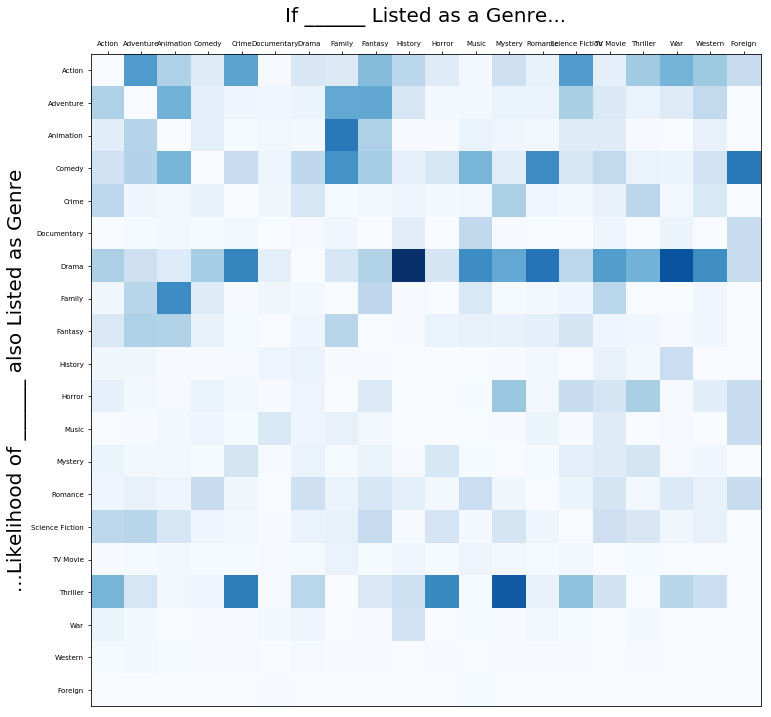

In [67]:
plot_heat_map(tmdb_genre_df, norm_genre_pairs_plot)

### Reducing Genres

In [33]:
tmdb_genre_df

,genre_id,genre
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [34]:
movies_genres_table.iloc[:10,:]

,movie_id,num_genres,id_1,id_2,id_3,id_4,id_5,id_6,id_7
0,293660,4,28,12,35,10749,NaN,NaN,NaN
1,297761,4,28,80,14,878,NaN,NaN,NaN
2,209112,3,28,12,14,NaN,NaN,NaN,NaN
3,271110,3,12,28,878,NaN,NaN,NaN,NaN
4,329865,4,53,18,878,9648,NaN,NaN,NaN
5,284052,4,28,12,14,878,NaN,NaN,NaN
6,246655,4,28,12,14,878,NaN,NaN,NaN
7,269149,4,16,12,10751,35,NaN,NaN,NaN
8,259316,3,12,28,14,NaN,NaN,NaN,NaN
9,330459,4,28,18,878,10752,NaN,NaN,NaN


In [35]:
def genre_reducer(movies_genres_table, genre_id_table, genre_id_to_change, new_genre_id):
    
    genre_id_table = genre_id_table[genre_id_table.genre_id != genre_id_to_change] # remove genre from genre list
    
    num_rows = movies_genres_table.shape[0]
    
    for row in range(0, num_rows):
        
        # pull out number of genres and genre id list
        num_ids = movies_genres_table.iloc[row, 1]
        id_list = movies_genres_table.iloc[row][2:(2 + num_ids)]

        # change genre ids
        for i in range(0, num_ids):
            if id_list[i] == genre_id_to_change:
                id_list[i] = new_genre_id
        
        new_id_list = list(set(id_list)) # remove duplicates
        new_num_ids = len(new_id_list) # get new number of genres

        # change movies genres table to reflect new genre ids
        movies_genres_table.iloc[row, 1] = new_num_ids 
        movies_genres_table.iloc[row][2:(2 + new_num_ids)] = new_id_list
        movies_genres_table.iloc[row][(2 + new_num_ids):] = 'NaN'
    
    return genre_id_table, movies_genres_table

In [36]:
genre_id_table = tmdb_genre_df.copy()
movies_genres = movies_genres_table.copy()

In [37]:
# change all "adventure" to "action"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 12, 28)

In [38]:
# change all "sci fi" to "action"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 878, 28)

In [39]:
# change all "war" to "drama"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 10752, 18)

In [40]:
# change all "western" to "drama"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 37, 18)

In [41]:
# change all "mystery" to "thriller"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 9648, 53)

In [42]:
# change all "horror" to "thriller"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 27, 53)

In [43]:
# change all "history" to "drama"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 36, 18)

In [44]:
# change all "tv movie" to "drama"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 10770, 18)

In [45]:
# change all "foreign" to "comedy"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 10769, 35)

In [46]:
# change all "fantasy" to "action"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 14, 28)

In [47]:
# change all "music" to "drama"
genre_id_table, movies_genres = genre_reducer(movies_genres, genre_id_table, 10402, 18)

In [48]:
### ADD/REMOVE GENRE CHANGES HERE

In [49]:
### ESP FOR "TV Movie", "Foreign" and other small genre catgegories...

In [50]:
movies_genres.iloc[:10,:]

,movie_id,num_genres,id_1,id_2,id_3,id_4,id_5,id_6,id_7
0,293660,3,35,28,10749,NaN,NaN,NaN,NaN
1,297761,2,80,28,NaN,NaN,NaN,NaN,NaN
2,209112,1,28,NaN,NaN,NaN,NaN,NaN,NaN
3,271110,1,28,NaN,NaN,NaN,NaN,NaN,NaN
4,329865,3,18,28,53,NaN,NaN,NaN,NaN
5,284052,1,28,NaN,NaN,NaN,NaN,NaN,NaN
6,246655,1,28,NaN,NaN,NaN,NaN,NaN,NaN
7,269149,4,16,35,28,10751,NaN,NaN,NaN
8,259316,1,28,NaN,NaN,NaN,NaN,NaN,NaN
9,330459,2,18,28,NaN,NaN,NaN,NaN,NaN


In [51]:
genre_id_table

,genre_id,genre
0,28,Action
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
13,10749,Romance
16,53,Thriller


In [52]:
genre_id_table = genre_id_table.reset_index(drop=True)
genre_id_table

,genre_id,genre
0,28,Action
1,16,Animation
2,35,Comedy
3,80,Crime
4,99,Documentary
5,18,Drama
6,10751,Family
7,10749,Romance
8,53,Thriller


### Table and Heat Map of Reduced Genre Relationships

In [53]:
genre_pairs_revised = create_genre_pairs(genre_id_table, movies_genres)
genre_pairs_revised

genre,Action,Animation,Comedy,Crime,Documentary,Drama,Family,Romance,Thriller
genre,,,,,,,,,
Action,1177,174,257,175,8,393,134,79,480
Animation,174,251,98,6,5,39,135,11,12
Comedy,257,98,1180,72,10,387,116,234,114
Crime,175,6,72,374,7,212,2,13,239
Documentary,8,5,10,7,201,51,7,0,3
Drama,393,39,387,212,51,1673,49,276,450
Family,134,135,116,2,7,49,225,12,3
Romance,79,11,234,13,0,276,12,435,41
Thriller,480,12,114,239,3,450,3,41,1206


In [54]:
genre_totals = get_genre_totals(genre_id_table, genre_pairs_revised)
genre_totals

,num_movies_with_genre
genre,
Action,1177
Animation,251
Comedy,1180
Crime,374
Documentary,201
Drama,1673
Family,225
Romance,435
Thriller,1206


In [55]:
norm_genre_pairs_revised = norm_genre_pairs(genre_id_table, genre_pairs_revised, genre_totals)
norm_genre_pairs_revised

genre,Action,Animation,Comedy,Crime,Documentary,Drama,Family,Romance,Thriller
genre,,,,,,,,,
Action,0.000000,0.693227,0.217797,0.467914,0.039801,0.234907,0.595556,0.181609,0.398010
Animation,0.147833,0.000000,0.083051,0.016043,0.024876,0.023311,0.600000,0.025287,0.009950
Comedy,0.218352,0.390438,0.000000,0.192513,0.049751,0.231321,0.515556,0.537931,0.094527
Crime,0.148683,0.023904,0.061017,0.000000,0.034826,0.126718,0.008889,0.029885,0.198176
Documentary,0.006797,0.019920,0.008475,0.018717,0.000000,0.030484,0.031111,0.000000,0.002488
Drama,0.333900,0.155378,0.327966,0.566845,0.253731,0.000000,0.217778,0.634483,0.373134
Family,0.113849,0.537849,0.098305,0.005348,0.034826,0.029289,0.000000,0.027586,0.002488
Romance,0.067120,0.043825,0.198305,0.034759,0.000000,0.164973,0.053333,0.000000,0.033997
Thriller,0.407816,0.047809,0.096610,0.639037,0.014925,0.268978,0.013333,0.094253,0.000000


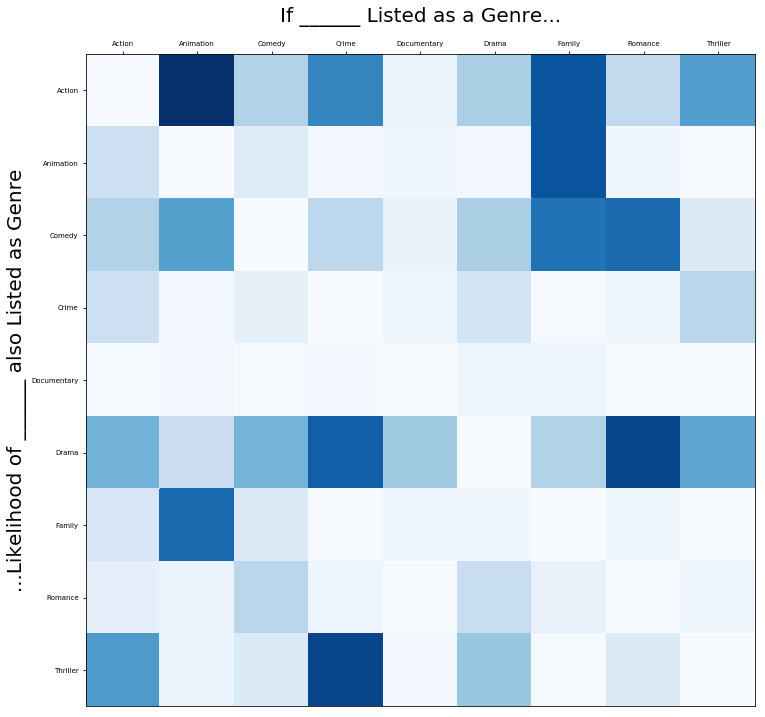

In [68]:
plot_heat_map(genre_id_table, norm_genre_pairs_revised)

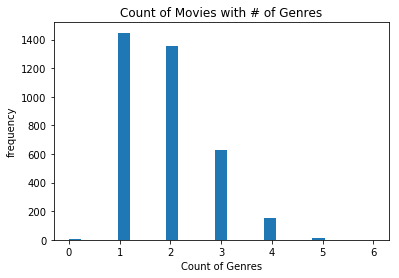

In [69]:
plt.hist(movies_genres['num_genres'].values, 
     25)
plt.title('Count of Movies with # of Genres')
plt.xlabel('Count of Genres')
plt.ylabel('frequency')

### Get Unique Genre Combos

In [114]:
num_genres = movies_genres.iloc[0, 1]

genres_list = list(movies_genres.iloc[0, 2:(2 + num_genres)])

genres_list.sort()

In [108]:
genres_as_list = list()

In [109]:
genres_as_list.append(genres_list)

In [110]:
genres_as_list.append(genres_list)

In [111]:
genres_as_list

[[28, 35, 10749], [28, 35, 10749]]